In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import uuid
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("fraud_data.csv")

In [3]:
df.shape

(6362620, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
 11  transaction_id  object 
dtypes: float64(5), int64(3), object(4)
memory usage: 582.5+ MB


In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transaction_id
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,e229deee-1ffc-4c39-9ea6-046cb66a274a
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,ce5d9129-d037-4621-94f3-acc688c9f80d
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,eb1beb60-0448-4290-ba83-8043b1a65036
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,c0f30e78-3412-40c5-9d9a-95f3442fe85c
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,7f79fb55-22e8-4279-bde3-5d5577d126cc


In [7]:
df['type'].value_counts()

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


<Axes: ylabel='count'>

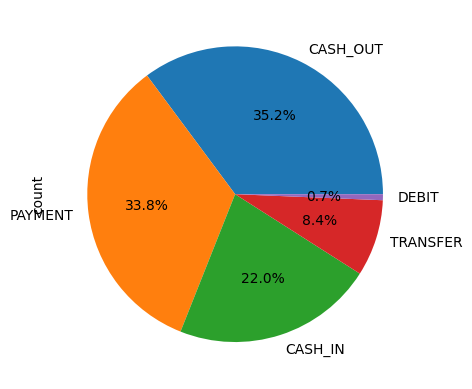

In [8]:
df['type'].value_counts().plot(kind='pie',autopct='%1.1f%%')

In [9]:
df.isFraud.value_counts()

,count
isFraud,
0,6354407
1,8213


In [10]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [6]:
df = df[["amount", "oldbalanceOrg","newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud"]]

In [7]:
df.shape

(6362620, 6)

In [8]:
X = df.drop("isFraud", axis = 1)
y = df['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
# Undersample majority class
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [10]:
X_resampled.shape, y_resampled.shape

((13140, 5), (13140,))

# Training Models

## Decision Tree

In [11]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Initialize base model
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

In [13]:
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='f1',   # change to 'accuracy' if needed
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search.fit(X_resampled, y_resampled)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1}
[[1255047   15834]
 [     10    1633]]
              precision    recall  f1-score   support

           0     1.0000    0.9875    0.9937   1270881
           1     0.0935    0.9939    0.1709      1643

    accuracy                         0.9875   1272524
   macro avg     0.5467    0.9907    0.5823   1272524
weighted avg     0.9988    0.9875    0.9927   1272524



In [ ]:
import joblib

joblib.dump(best_model, "decision_tree.pkl")

['decision_tree.pkl']